# Tutorial Part 5: Lambda Dependent corrections 

<img align="left" src = ../_static/images/logo044.jpg width=120 style="padding: 10px"> 
<br><b>Dark Energy Survey Supernova Program</b>

<b>Tutorial Part 5</b>
<b>Lambda Dependent corrections</b> <br>
Contact author: Jason Lee<br>

Here, we demonstrate how we obtain our magnitude corrections for the SHAPE (DCR + $\lambda$-dependent seeing) and COORD (DCR only) effects starting from the flux ratio tables and the altitude offset vs. g-i magnitude for each exposure. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy.coordinates import Angle
from astropy.coordinates import AltAz, ICRS
from scipy.interpolate import interp1d

/var/folders/61/jz5zv4qn1ml4kvb_mzhpz5500000gn/T/ipykernel_74666/2027958474.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'scipy'

In [ ]:
earth_location = EarthLocation.of_site('ctio')

In [2]:
DES_5YR_DCR_path = 'DES-SN5YR_DR_DCR/'

1. SHAPE effect (starting from the flux ratio (correct vs. uncorrected) tables)

In [3]:
# Reading tables for SHAPE effect

# flux ratio values table gives the flux ratio to when using the average color star as the PSF
# table columns = g-i values, AM_values, PSF FWHM values in arcseconds

flux_ratio_values_g_table = np.load(DES_5YR_DCR_path + 'flux_ratio_values_g_table_DCR_shape.npy')
g_table_columns = np.load(DES_5YR_DCR_path + 'g_table_DCR_shape_xyz_columns.npy', allow_pickle=True)

flux_ratio_values_r_table = np.load(DES_5YR_DCR_path + 'flux_ratio_values_r_table_DCR_shape.npy')
r_table_columns = np.load(DES_5YR_DCR_path + 'r_table_DCR_shape_xyz_columns.npy', allow_pickle=True)

In [4]:
# Using the GridInterpolator to 3D interpolate between the column values and flux ratio

g_i_values_g, AM_values_g, psf_fwhms_g = g_table_columns
g_i_values_r, AM_values_r, psf_fwhms_r = r_table_columns
flux_interp_g_all = RegularGridInterpolator((g_i_values_g, AM_values_g, psf_fwhms_g), flux_ratio_values_g_table, bounds_error=False, fill_value = None)
flux_interp_r_all = RegularGridInterpolator((g_i_values_r, AM_values_r, psf_fwhms_r), flux_ratio_values_r_table, bounds_error=False, fill_value = None)


In [5]:
# MCOR_220929 contains all the MAGCORs (both COORD and SHAPE) to be added to the uncorrected (SALT2 or SALT3) magnitudes

MCOR_220929 = pd.read_csv(DES_5YR_DCR_path + 'DCRADJ_MAGCOR_v220929.csv')
MCOR_220929.head()



,Unnamed: 0,Unnamed: 0.1,CID,EXPNUM,CCDNUM,MJD,BAND,TREST,LAMREST,SNR,...,HA,dRA,dDEC,CUTS,ddRA,ddDEC,ADJOFF,PSF_FWHM_ASEC,MAGCOR_COORD,MAGCOR_SHAPE
0,0,3627,1246281,255449,51,56614.0731,g,49.2,3613.5,1.7,...,b'-02:46:38.520',0.017590,0.004682,True,0.038003,0.009945,0.039283,0.927,-0.002618,0.002402
1,1,3655,1246281,255888,51,56615.0961,g,49.9,3613.5,1.8,...,b'-02:09:31.400',0.012814,0.003172,True,0.033227,0.008435,0.034281,0.997,-0.001724,0.001877
2,2,4066,1246281,238052,51,56559.1905,g,8.1,3613.5,5.0,...,b'-03:33:58.020',-0.022856,-0.007003,True,-0.002442,-0.001740,0.002999,1.330,-0.000007,-0.004349
3,3,4080,1246281,238984,51,56563.2002,g,11.1,3613.5,9.0,...,b'-03:04:13.260',-0.017628,-0.004924,True,0.002786,0.000338,0.002806,1.344,-0.000006,-0.003640
4,4,4108,1246281,242477,51,56575.1914,g,20.1,3613.5,5.2,...,b'-02:29:35.140',0.001841,0.000471,True,0.022254,0.005734,0.022981,0.925,-0.000900,0.001309


In [6]:
# SHAPE example for one candidate at a particular exposure

ind = 0

EX_g_i = MCOR_220929.iloc[ind]['MAG_MODEL_g'] - MCOR_220929.iloc[ind]['MAG_MODEL_i']
EX_AM = MCOR_220929.iloc[ind]['AIRMASS']
EX_PSF_FWHM = MCOR_220929.iloc[ind]['PSF_FWHM_ASEC']

# Convert flux ratio to magnitude correction

EX_MAG_COR_SHAPE = -2.5/np.log(10) * (1. - flux_interp_g_all([EX_g_i, EX_AM, EX_PSF_FWHM])) 

# Compare with MAGCOR file

print(EX_MAG_COR_SHAPE, MCOR_220929.iloc[ind]['MAGCOR_SHAPE'])

[0.00240155] 0.0024015458236172


2. COORD effect (starting from altitude shift vs. g-i magnitude)

In [7]:
# Reading tables for COORD

coord_dictionary = pd.read_csv(DES_5YR_DCR_path + 'DCR_dictionary.csv')
mag_corr_vs_offset = np.loadtxt(DES_5YR_DCR_path + 'mmag_vs_fracpsf_Moffat3.txt')

In [8]:
DCR_coord_table = pd.read_csv(DES_5YR_DCR_path + 'DCR_coord_table.csv')

In [9]:
DES_bands = ['g', 'r', 'i', 'z']

In [10]:
where_band = []
for i in range(len(DES_bands)):
    where_band.append(np.where(MCOR_220929['BAND'] == DES_bands[i][0]))

In [11]:
# COORD example

expnums = MCOR_220929['EXPNUM'].values

g_i_vals = MCOR_220929['MAG_MODEL_g'].values - MCOR_220929['MAG_MODEL_i'].values


In [12]:
# Altitude slope and y intercept values for each exposure

slope_y_int_vals = np.zeros([2, len(MCOR_220929)])

for i in range(len(slope_y_int_vals[0])):
    dict_ = coord_dictionary[coord_dictionary['EXPNUM'] == expnums[i]]
    slope_y_int_vals[0][i] = dict_['SLOPE_ALT']
    slope_y_int_vals[1][i] = dict_['YINT_ALT']


In [13]:
# Convert to altitude shifts: see Figure 5 of Lee & Acevedo et. al (2023) https://arxiv.org/abs/2304.01858

alt_shift_vals = g_i_vals * slope_y_int_vals[0] + slope_y_int_vals[1]

In [14]:
def sky_to_alt_az_coords(SN_fid_pos, mjd, loc = earth_location):
    coord0 = SkyCoord(SN_fid_pos[0] * u.deg, SN_fid_pos[1] * u.deg)
    aa = AltAz(location=loc, obstime=Time(mjd, scale = 'utc', format = 'mjd', location = loc))
    alt, az = coord0.transform_to(aa).alt, coord0.transform_to(aa).az 
    return alt, az

def alt_az_to_sky_coords(alt, az, mjd, loc=earth_location):
    # Create AltAz object
    aa = AltAz(alt=alt*u.deg, az=az*u.deg, location=loc, obstime=Time(mjd, format='mjd'))
    
    # Transform AltAz to Equatorial coordinates (ICRS)
    equatorial_coords = aa.transform_to(ICRS())
    
    # Extract RA and DEC
    ra, dec = equatorial_coords.ra, equatorial_coords.dec
    
    return ra, dec

In [15]:
nominal_RA_vals, nominal_DEC_vals = MCOR_220929['RADEG'].values, MCOR_220929['DECDEG'].values
mjds = MCOR_220929['MJD'].values

alt_deg, az_deg = sky_to_alt_az_coords([nominal_RA_vals, nominal_DEC_vals], mjds)


In [16]:
lat = earth_location.lat.value

sinq = -np.cos(lat*u.deg)*np.sin(az_deg)/np.cos(nominal_DEC_vals*u.deg)
cosq = (np.sin(lat*u.deg)-np.sin(nominal_DEC_vals*u.deg)*np.sin(alt_deg))/(np.cos(nominal_DEC_vals*u.deg)*np.cos(alt_deg))

In [17]:
# Convert altitude shifts to dRA, dDEC

dRA, dDEC = alt_shift_vals*sinq, alt_shift_vals*cosq

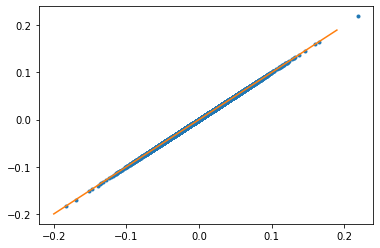

In [18]:
# Checking dRA dDEC with csv file

plt.plot(dRA[np.where(MCOR_220929['BAND'] == 'g')[0]], MCOR_220929[MCOR_220929['BAND'] == 'g']['dRA'], '.')

plt.plot(np.arange(-0.2, 0.2, 0.01), np.arange(-0.2, 0.2, 0.01))

In [19]:
MCOR_220929['CID'].unique()

array([1246281, 1246430, 1246527, ..., 1959025, 1960031, 1974019])

In [20]:
cid, band = 1246281, 'g'
where_cid_band = np.where((MCOR_220929['CID'] == cid) & (MCOR_220929['BAND'] == band))[0]
SNR_where_cid_band = MCOR_220929['SNR'][where_cid_band]

# COORD shift in RA, DEC with respect to the SNR^2 weighted average

ddRA_cid_band, ddDEC_cid_band = dRA[where_cid_band] - np.average(dRA[where_cid_band], weights = SNR_where_cid_band**2), dDEC[where_cid_band] - np.average(dDEC[where_cid_band], weights = SNR_where_cid_band**2)

(-0.00738635890821312, 0.0551164154097413)

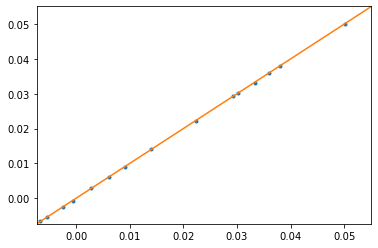

In [21]:
# Check ddRA, ddDEC with csv file

plt.plot(ddRA_cid_band, MCOR_220929['ddRA'][where_cid_band], '.')
plt.plot(np.arange(-0.2, 0.2, 0.01), np.arange(-0.2, 0.2, 0.01))
plt.xlim(ddRA_cid_band.min()*1.1, ddRA_cid_band.max()*1.1)
plt.ylim(MCOR_220929['ddRA'][where_cid_band].min()*1.1, MCOR_220929['ddRA'][where_cid_band].max()*1.1)


In [22]:
# Total OFFSET

ADJOFF_cid_band = np.sqrt(ddRA_cid_band**2 + ddDEC_cid_band**2)
print(ADJOFF_cid_band, MCOR_220929['ADJOFF'][where_cid_band].values)

[0.03932834 0.03434253 0.00299094 0.00280766 0.02298685 0.03114068
 0.01049225 0.03709824 0.03020881 0.05214196 0.00630405 0.00941435
 0.01432433 0.00558399 0.00694969] [0.0392828  0.03428121 0.00299867 0.0028061  0.02298113 0.03108189
 0.01050769 0.03708267 0.03018175 0.05217067 0.00628068 0.00938201
 0.01433384 0.00562435 0.00692192]


In [23]:
# Convert to offset in multiples of PSF FWHM (Figure 4 of Lee & Acevedo et al. (2023))

OFF_PSF_FWHM_cid_band = ADJOFF_cid_band/MCOR_220929['PSF_FWHM_ASEC'][where_cid_band].values

In [24]:
# Interpolate mag correction by offset

coord_off, magoff = mag_corr_vs_offset[0], mag_corr_vs_offset[1]
magoff_interp = interp1d(coord_off, magoff)

(0.0, 15.0)

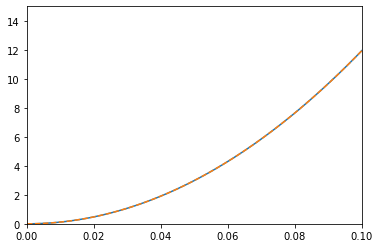

In [25]:
# Figure 4 for the Moffat profile

plt.plot(mag_corr_vs_offset[0], mag_corr_vs_offset[1])
plt.plot(coord_off, magoff_interp(coord_off), ls = '--')
plt.xlim(0, 0.10)
plt.ylim(0, 15)

[-0.82161476 -0.82300294 -0.91907314 -0.94210969 -0.82027624 -0.82292534
 -0.8261532  -0.82059541 -0.82148971 -0.81899311 -0.84834005 -0.83548809
 -0.822037   -0.83689179 -0.84754167]


(-0.002618313475896, 0.0)

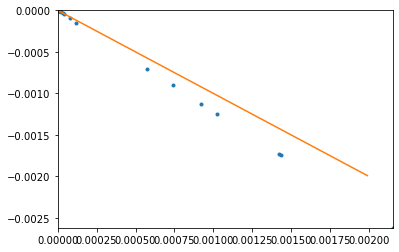

In [26]:
# Compare with csv file

plt.plot(magoff_interp(OFF_PSF_FWHM_cid_band)*1e-3, MCOR_220929['MAGCOR_COORD'][where_cid_band].values, '.')
plt.plot(np.arange(0, 0.002, 0.00001), -np.arange(0, 0.002, 0.00001))

print(magoff_interp(OFF_PSF_FWHM_cid_band)*1e-3/MCOR_220929['MAGCOR_COORD'][where_cid_band].values)

plt.xlim(0, magoff_interp(OFF_PSF_FWHM_cid_band).max()*1e-3)
plt.ylim(MCOR_220929['MAGCOR_COORD'][where_cid_band].values.min(), 0)